In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

In [2]:
import gym
from memory import EpisodicMemory, SemanticMemory
from memory.utils import seed_everything
from itertools import count
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import room_env


def episodic(env_params, caps, seed):

    seed_everything(seed)
    env = gym.make("RoomEnv-v0")

    results = []
    for capacity in caps:
        rewards = {}
        for forget_policy in ["oldest", "random"]:
            for answer_policy in ["latest", "random"]:

                rewards[f"{forget_policy}_{answer_policy}"] = 0
                M_e = EpisodicMemory(capacity)
                ob, question = env.reset()
                ob = ob[0]

                M_e.add(EpisodicMemory.ob2epi(ob))

                for t in count():
                    if M_e.is_full:
                        if forget_policy == "random":
                            M_e.forget_random()
                        else:
                            M_e.forget_oldest()

                    if answer_policy == "latest":
                        pred = M_e.answer_latest(question)
                    else:
                        pred = M_e.answer_random(question)

                    (ob, question), reward, done, info = env.step(pred)
                    ob = ob[0]

                    M_e.add(EpisodicMemory.ob2epi(ob))

                    rewards[f"{forget_policy}_{answer_policy}"] += reward
                    # print(f"ob: {ob}, question: {question}, M_e: {M_e}, pred: {pred}")
                    if done:
                        break

        rewards["info"] = {"seed": seed, "capacity": capacity}
        results.append(rewards)
        print(capacity, rewards)
        print()

    return results


def semantic(env_params, caps, seed):

    seed_everything(seed)
    env = gym.make("RoomEnv-v0")

    results = []
    for capacity in caps:
        rewards = {}
        for forget_policy in ["weakest", "random"]:
            for answer_policy in ["strongest", "random"]:

                rewards[f"{forget_policy}_{answer_policy}"] = 0
                M_s = SemanticMemory(capacity)
                ob, question = env.reset()
                ob = ob[0]
                M_s.add(SemanticMemory.ob2sem(ob))

                for t in count():
                    if M_s.is_full:
                        if forget_policy == "random":
                            M_s.forget_random()
                        elif forget_policy == "weakest":
                            M_s.forget_weakest()
                        else:
                            raise ValueError

                    if answer_policy == "strongest":
                        pred = M_s.answer_strongest(question)
                    else:
                        pred = M_s.answer_random(question)

                    (ob, question), reward, done, info = env.step(pred)
                    ob = ob[0]

                    M_s.add(SemanticMemory.ob2sem(ob))

                    rewards[f"{forget_policy}_{answer_policy}"] += reward

                    if done:
                        break

        rewards["info"] = {"seed": seed, "capacity": capacity}
        results.append(rewards)
        print(capacity, rewards)
        print()

    return results


def episodic_semantic(env_params, caps, seed):

    seed_everything(seed)
    env = gym.make("RoomEnv-v0")

    results = []
    for capacity in caps:
        rewards = {}
        for forget_policy in ["generalize", "random"]:
            for answer_policy in ["episem", "random"]:

                rewards[f"{forget_policy}_{answer_policy}"] = 0
                M_e = EpisodicMemory(capacity // 2)
                M_s = SemanticMemory(capacity // 2)

                ob, question = env.reset()
                ob = ob[0]
                if forget_policy == "random":
                    if random.random() < 0.5:
                        M_e.add(EpisodicMemory.ob2epi(ob))
                    else:
                        M_s.add(SemanticMemory.ob2sem(ob))
                else:
                    M_e.add(EpisodicMemory.ob2epi(ob))

                for t in count():
                    if M_e.is_full:
                        if forget_policy == "random":
                            M_e.forget_random()

                        elif forget_policy == "generalize":

                            mem_epi = M_e.find_mem_for_semantic()
                            M_e.forget(mem_epi)
                            mem_sem = SemanticMemory.ob2sem(mem_epi)
                            M_s.add(mem_sem)

                            if M_s.is_full:
                                M_s.forget_weakest()

                        else:
                            raise ValueError

                    if M_s.is_full:
                        assert forget_policy == "random"
                        M_s.forget_random()

                    if answer_policy == "episem":
                        if M_e.is_answerable(question):
                            pred = M_e.answer_latest(question)
                        else:
                            pred = M_s.answer_strongest(question)
                    else:
                        pred = random.choice(
                            [M_e.answer_random(question), M_s.answer_random]
                        )

                    (ob, question), reward, done, info = env.step(pred)
                    ob = ob[0]

                    if forget_policy == "random":
                        if random.random() < 0.5:
                            M_e.add(EpisodicMemory.ob2epi(ob))
                        else:
                            M_s.add(SemanticMemory.ob2sem(ob))
                    else:
                        M_e.add(EpisodicMemory.ob2epi(ob))

                    rewards[f"{forget_policy}_{answer_policy}"] += reward

                    if done:
                        break

        rewards["info"] = {"seed": seed, "capacity": capacity}
        results.append(rewards)
        print(capacity, rewards)
        print()

    return results


def episodic_semantic_pretrain(env_params, caps, seed):

    seed_everything(seed)
    env = gym.make("RoomEnv-v0")

    results = []
    for capacity in caps:
        rewards = {}
        for forget_policy in ["oldest", "random"]:
            for answer_policy in ["episem", "random"]:

                rewards[f"{forget_policy}_{answer_policy}"] = 0
                M_e = EpisodicMemory(capacity // 2)
                M_s = SemanticMemory(capacity // 2)

                free_space = M_s.pretrain_semantic(env)
                M_e.increase_capacity(free_space)
                assert M_e.capacity + M_s.capacity == capacity

                ob, question = env.reset()
                ob = ob[0]
                M_e.add(EpisodicMemory.ob2epi(ob))

                for t in count():
                    if M_e.is_full:
                        if forget_policy == "random":
                            M_e.forget_random()

                        elif forget_policy == "oldest":

                            M_e.forget_oldest()
                        else:
                            raise ValueError

                    if answer_policy == "episem":
                        if M_e.is_answerable(question):
                            pred = M_e.answer_latest(question)
                        else:
                            pred = M_s.answer_strongest(question)
                    else:
                        pred = random.choice(
                            [M_e.answer_random(question), M_s.answer_random]
                        )

                    (ob, question), reward, done, info = env.step(pred)
                    ob = ob[0]

                    M_e.add(EpisodicMemory.ob2epi(ob))

                    rewards[f"{forget_policy}_{answer_policy}"] += reward

                    if done:
                        break

        rewards["info"] = {"seed": seed, "capacity": capacity}
        results.append(rewards)
        print(capacity, rewards)
        print()

    return results


seed = 42
caps = [4, 10, 20, 30]
# caps = [10]

env_params = {
    "semantic_knowledge_path": "./data/semantic-knowledge-small.json",
    "names_path": "./data/top-human-names-small",
    "weighting_mode": "highest",
    "probs": {
        "commonsense": 0.6,
        "new_location": 0.1,
        "new_object": 0.2,
        "switch_person": 0.3,
    },
    "limits": {
        "heads": None,
        "tails": None,
        "names": None,
        "allow_spaces": False,
    },
    "max_step": 1000,
    "disjoint_entities": True,
    "num_agents": 1,
}
seed_everything(seed)
env = gym.make("RoomEnv-v0")

print(len(env.heads))
print(len(env.tails))
print(len(env.names))

# {'10': '0.7_0.1_0.4_0.5',
#  '20': '0.7_0.1_0.4_0.2',
#  '30': '0.7_0.1_0.5_0.7',
#  '40': '0.7_0.1_0.6_0.7'}

10
10
10


In [3]:
results_all = {}
results_all["episodic"] = []
results_all["semantic"] = []
results_all["both"] = []
results_all["both-presem"] = []
seeds = [0, 1, 2]

for seed in tqdm(seeds):
    results_all["episodic"].append(episodic(env_params, caps, seed))
    results_all["semantic"].append(semantic(env_params, caps, seed))
    results_all["both"].append(episodic_semantic(env_params, caps, seed))
    results_all["both-presem"].append(
        episodic_semantic_pretrain(env_params, caps, seed)
    )

  0%|          | 0/3 [00:00<?, ?it/s]

4 {'oldest_latest': 0, 'oldest_random': 0, 'random_latest': 0, 'random_random': 0, 'info': {'seed': 0, 'capacity': 4}}

10 {'oldest_latest': 0, 'oldest_random': 0, 'random_latest': 0, 'random_random': 0, 'info': {'seed': 0, 'capacity': 10}}

20 {'oldest_latest': 0, 'oldest_random': 0, 'random_latest': 0, 'random_random': 0, 'info': {'seed': 0, 'capacity': 20}}

30 {'oldest_latest': 0, 'oldest_random': 0, 'random_latest': 0, 'random_random': 0, 'info': {'seed': 0, 'capacity': 30}}

4 {'weakest_strongest': 0, 'weakest_random': 0, 'random_strongest': 0, 'random_random': 0, 'info': {'seed': 0, 'capacity': 4}}

10 {'weakest_strongest': 0, 'weakest_random': 0, 'random_strongest': 0, 'random_random': 0, 'info': {'seed': 0, 'capacity': 10}}

20 {'weakest_strongest': 0, 'weakest_random': 0, 'random_strongest': 0, 'random_random': 0, 'info': {'seed': 0, 'capacity': 20}}

30 {'weakest_strongest': 0, 'weakest_random': 0, 'random_strongest': 0, 'random_random': 0, 'info': {'seed': 0, 'capacity': 30

In [10]:
def get_stats(list_of_dicts: list):
    keys = list(list_of_dicts[0].keys())
    keys.remove("info")

    stats = {}
    for key in keys:
        stats[key] = {
            "mean": round(np.mean([foo[key] for foo in list_of_dicts]), 4),
            "std": round(np.std([foo[key] for foo in list_of_dicts]), 4),
        }

    return stats

In [11]:
stats_all = {}
for key, val in results_all.items():
    stats_all[key] = {}
    for capacity in caps:
        foo = [bar for foo in val for bar in foo if bar["info"]["capacity"] == capacity]
        stats = get_stats(foo)
        stats_all[key][capacity] = stats

        print(stats)
        print()

{'oldest_latest': {'mean': 0.0, 'std': 0.0}, 'oldest_random': {'mean': 0.0, 'std': 0.0}, 'random_latest': {'mean': 0.0, 'std': 0.0}, 'random_random': {'mean': 0.0, 'std': 0.0}}

{'oldest_latest': {'mean': 0.0, 'std': 0.0}, 'oldest_random': {'mean': 0.0, 'std': 0.0}, 'random_latest': {'mean': 0.0, 'std': 0.0}, 'random_random': {'mean': 0.0, 'std': 0.0}}

{'oldest_latest': {'mean': 0.0, 'std': 0.0}, 'oldest_random': {'mean': 0.0, 'std': 0.0}, 'random_latest': {'mean': 0.0, 'std': 0.0}, 'random_random': {'mean': 0.0, 'std': 0.0}}

{'oldest_latest': {'mean': 0.0, 'std': 0.0}, 'oldest_random': {'mean': 0.0, 'std': 0.0}, 'random_latest': {'mean': 0.0, 'std': 0.0}, 'random_random': {'mean': 0.0, 'std': 0.0}}

{'weakest_strongest': {'mean': 0.0, 'std': 0.0}, 'weakest_random': {'mean': 0.0, 'std': 0.0}, 'random_strongest': {'mean': 0.0, 'std': 0.0}, 'random_random': {'mean': 0.0, 'std': 0.0}}

{'weakest_strongest': {'mean': 0.0, 'std': 0.0}, 'weakest_random': {'mean': 0.0, 'std': 0.0}, 'random_

In [12]:
stats_best = {}
best_keys = ["oldest_latest", "weakest_strongest", "generalize_episem", "oldest_episem"]

for key, val in stats_all.items():
    stats_best[key] = {}
    for key_, val_ in val.items():
        for key__, val__ in val_.items():
            if key__ in best_keys:
                stats_best[key][key_] = val__

In [13]:
stats_best

{'episodic': {4: {'mean': 0.0, 'std': 0.0},
  10: {'mean': 0.0, 'std': 0.0},
  20: {'mean': 0.0, 'std': 0.0},
  30: {'mean': 0.0, 'std': 0.0}},
 'semantic': {4: {'mean': 0.0, 'std': 0.0},
  10: {'mean': 0.0, 'std': 0.0},
  20: {'mean': 0.0, 'std': 0.0},
  30: {'mean': 0.0, 'std': 0.0}},
 'both': {4: {'mean': 0.0, 'std': 0.0},
  10: {'mean': 0.0, 'std': 0.0},
  20: {'mean': 0.0, 'std': 0.0},
  30: {'mean': 0.0, 'std': 0.0}},
 'both-presem': {4: {'mean': 0.0, 'std': 0.0},
  10: {'mean': 0.0, 'std': 0.0},
  20: {'mean': 0.0, 'std': 0.0},
  30: {'mean': 0.0, 'std': 0.0}}}

episodic [0.0, 0.0, 0.0, 0.0]
semantic [0.0, 0.0, 0.0, 0.0]
both [0.0, 0.0, 0.0, 0.0]
both-presem [0.0, 0.0, 0.0, 0.0]


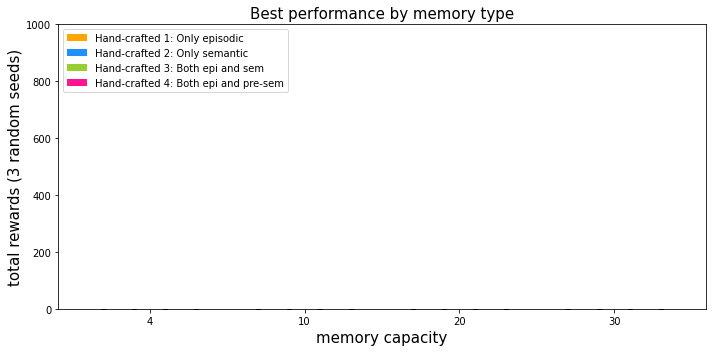

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
idx = np.asanyarray([i for i in range(len(caps))])
width = 0.2

memory_order = ["episodic", "semantic", "both", "both-presem"]

legend_order = [
    "Hand-crafted 1: Only episodic",
    "Hand-crafted 2: Only semantic",
    "Hand-crafted 3: Both epi and sem",
    "Hand-crafted 4: Both epi and pre-sem",
]

color_order = ["orange", "dodgerblue", "yellowgreen", "deeppink"]

for memory_type, w, color in zip(memory_order, [-1.5, -0.5, 0.5, 1.5], color_order):
    means = [stats_best[memory_type][capacity]["mean"] for capacity in caps]
    stds = [stats_best[memory_type][capacity]["std"] for capacity in caps]

    print(memory_type, means)
    ax.bar(
        x=idx + w * width,
        height=means,
        yerr=stds,
        width=width,
        color=color,
        capsize=2,
    )
    ax.set_xticks(idx)
    ax.set_xticklabels(caps)
    ax.legend(legend_order, fontsize=10, loc="upper left")
    ax.set_xlabel("memory capacity", fontsize=15)
    ax.set_ylabel(f"total rewards ({len(seeds)} random seeds)", fontsize=15)

    ax.set_ylim([0, env_params["max_step"]])

    fig.tight_layout()
    plt.title("Best performance by memory type", fontsize=15)
    plt.savefig("./figures/best-strategies.pdf", bbox_inches="tight")
    # plt.show()

oldest_latest [0.0, 0.0, 0.0, 0.0]
random_latest [0.0, 0.0, 0.0, 0.0]
oldest_random [0.0, 0.0, 0.0, 0.0]
random_random [0.0, 0.0, 0.0, 0.0]
weakest_strongest [0.0, 0.0, 0.0, 0.0]
random_strongest [0.0, 0.0, 0.0, 0.0]
weakest_random [0.0, 0.0, 0.0, 0.0]
random_random [0.0, 0.0, 0.0, 0.0]
generalize_episem [0.0, 0.0, 0.0, 0.0]
random_episem [0.0, 0.0, 0.0, 0.0]
generalize_random [0.0, 0.0, 0.0, 0.0]
random_random [0.0, 0.0, 0.0, 0.0]
oldest_episem [0.0, 0.0, 0.0, 0.0]
random_episem [0.0, 0.0, 0.0, 0.0]
oldest_random [0.0, 0.0, 0.0, 0.0]
random_random [0.0, 0.0, 0.0, 0.0]


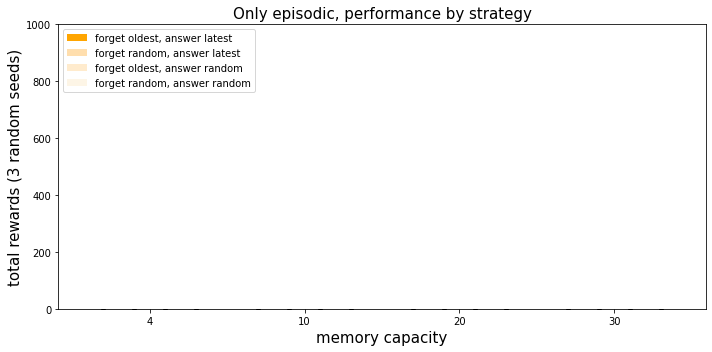

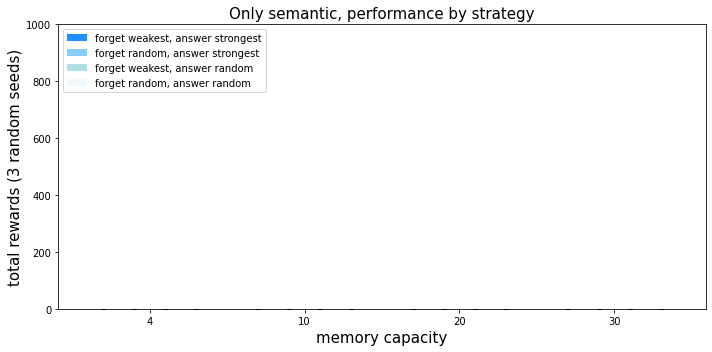

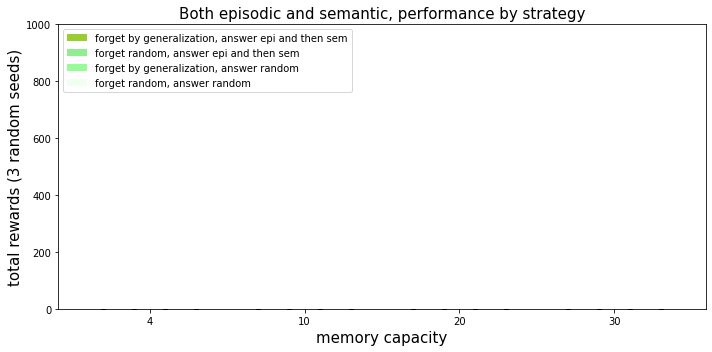

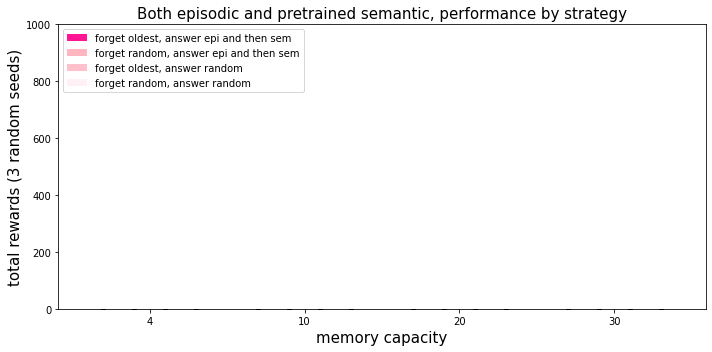

In [9]:
idx = np.asanyarray([i for i in range(len(caps))])
width = 0.2

for memory_type in ["episodic", "semantic", "both", "both-presem"]:

    fig, ax = plt.subplots(figsize=(10, 5))

    if memory_type == "episodic":
        strategy_order = [
            "oldest_latest",
            "random_latest",
            "oldest_random",
            "random_random",
        ]

        legend_order = [
            "forget oldest, answer latest",
            "forget random, answer latest",
            "forget oldest, answer random",
            "forget random, answer random",
        ]

        color_order = ["orange", "navajowhite", "blanchedalmond", "oldlace"]

    elif memory_type == "semantic":
        strategy_order = [
            "weakest_strongest",
            "random_strongest",
            "weakest_random",
            "random_random",
        ]

        legend_order = [
            "forget weakest, answer strongest",
            "forget random, answer strongest",
            "forget weakest, answer random",
            "forget random, answer random",
        ]

        color_order = ["dodgerblue", "lightskyblue", "powderblue", "aliceblue"]

    elif memory_type == "both":
        strategy_order = [
            "generalize_episem",
            "random_episem",
            "generalize_random",
            "random_random",
        ]

        legend_order = [
            "forget by generalization, answer epi and then sem",
            "forget random, answer epi and then sem",
            "forget by generalization, answer random",
            "forget random, answer random",
        ]

        color_order = ["yellowgreen", "lightgreen", "palegreen", "honeydew"]

    elif memory_type == "both-presem":
        strategy_order = [
            "oldest_episem",
            "random_episem",
            "oldest_random",
            "random_random",
        ]

        legend_order = [
            "forget oldest, answer epi and then sem",
            "forget random, answer epi and then sem",
            "forget oldest, answer random",
            "forget random, answer random",
        ]

        color_order = ["deeppink", "lightpink", "pink", "lavenderblush"]

    else:
        raise ValueError

    for strategy_type, w, color in zip(
        strategy_order, [-1.5, -0.5, 0.5, 1.5], color_order
    ):
        means = [
            stats_all[memory_type][capacity][strategy_type]["mean"] for capacity in caps
        ]
        stds = [
            stats_all[memory_type][capacity][strategy_type]["std"] for capacity in caps
        ]

        print(strategy_type, means)
        ax.bar(
            x=idx + w * width,
            height=means,
            yerr=stds,
            width=width,
            color=color,
            capsize=2,
        )
        ax.set_xticks(idx)
        ax.set_xticklabels(caps)
        ax.legend(legend_order, fontsize=10, loc="upper left")
        ax.set_xlabel("memory capacity", fontsize=15)
        ax.set_ylabel(f"total rewards ({len(seeds)} random seeds)", fontsize=15)

        ax.set_ylim([0, env_params["max_step"]])

        fig.tight_layout()
        if memory_type == "episodic":
            title = "Only episodic, performance by strategy"
        elif memory_type == "semantic":
            title = "Only semantic, performance by strategy"
        elif memory_type == "both":
            title = "Both episodic and semantic, performance by strategy"
        elif memory_type == "both-presem":
            title = "Both episodic and pretrained semantic, performance by strategy"
        else:
            raise ValueError

        plt.title(title, fontsize=15)
        plt.savefig(f"./figures/{memory_type}.pdf", bbox_inches="tight")